# Data Analysis
## Saisriram Gurajala
## 10/29/2024

This notebook uses the files generated by the code in `data_loading.ipynb`, and performs the required data manipulation and analysis.

### Import Libraries and Read in Files

Hear we read in the required libraries and files to run the rest of this notebook.

In [7]:
import json 
import os
import pandas as pd 
from PIL import Image
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import numpy as np
from scipy.stats import spearmanr, pearsonr
from statsmodels.tsa.holtwinters import ExponentialSmoothing
os.chdir(os.getenv("DATA512_BASE_FILE_PATH"))

In [4]:
dearborn_mi_aqi_df = pd.read_csv("./data/AQI_Dearborn_Michigan.csv")
with open("./data/USGS_Wildland_Fire_Combined_Dataset_filtered.json", "r") as file:
    filtered_fire_json = json.load(file)

### Transform Fire JSON

We next need to manipulate the input json, and produce a pandas data frame. When constructing the metric for smoke estimates, we need to only consider fires within 650 miles. We will also create a separate data frame with just this data in it. We also restrict to just Wildfires for FireType.

In [5]:
fire_dataframes = []
for fire in filtered_fire_json:
    fire_df = pd.DataFrame({"FireType" : [fire['Assigned_Fire_Type']],
                            "Year" : [fire['Fire_Year']],
                            "Acreage" : [fire["GIS_Acres"]],
                            "Distance_to_Dearborn" : [fire["Distance_to_DearbornMI"]]})
    fire_dataframes.append(fire_df)
fire_df = pd.concat(fire_dataframes)
fire_df = fire_df[fire_df['FireType'] == "Wildfire"]
fire_df_650mi = fire_df[fire_df.Distance_to_Dearborn <= 650]

### Visualizations

#### Visualization 1: Histogram

Here we visualize the number of fires for every 50 miles from my given city, Dearborn, MI, up to 1800 miles.

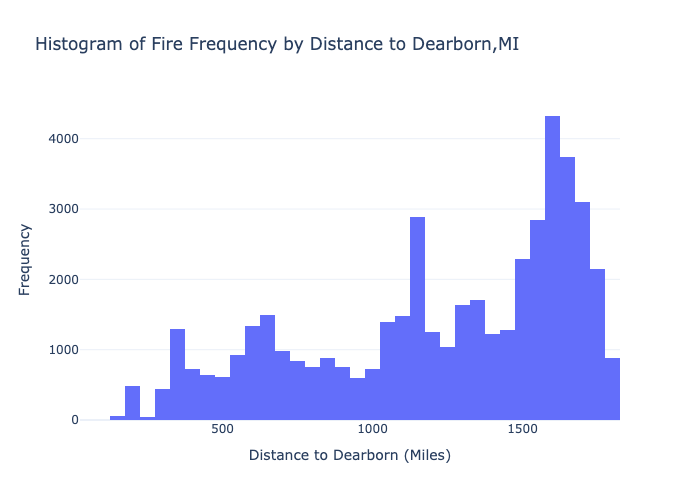

In [8]:
fig = go.Figure(data=[go.Histogram(
    x=fire_df['Distance_to_Dearborn'],
    xbins=dict(
        size=50
    )
)])
fig.update_layout(title_text='Histogram of Fire Frequency by Distance to Dearborn,MI',
                  xaxis_title="Distance to Dearborn (Miles)",
                  yaxis_title="Frequency",
                  template='plotly_white')
fig.write_image("./imgs/histogram_plot.png")
img = Image.open("./imgs/histogram_plot.png")
display(img)

### Visualization 2: Acreage Burned by Year

Here, we visualize the number of acres burned per year within 650 miles of the city.

In [12]:
#aggregate acreage by year
plotting_df = pd.DataFrame(fire_df_650mi.groupby("Year", as_index = False)["Acreage"].sum())

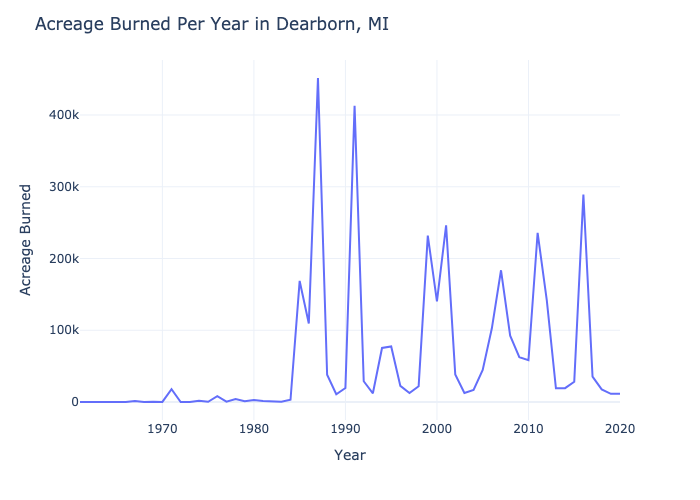

In [14]:
#plotting code
fig = px.line(x=plotting_df['Year'], y=plotting_df['Acreage']) 
fig.update_layout(xaxis_title = "Year", yaxis_title = "Acreage Burned",
                  title = "Acreage Burned Per Year in Dearborn, MI",
                  template='plotly_white')
fig.write_image("./imgs/acreage_burned_line_plot.png")
img = Image.open("./imgs/acreage_burned_line_plot.png")
display(img)

### Visualization 3: AQI vs Smoke Metric Line Plot

#### Creating the Smoke Metric

##### In Collaboration with Daniel Vogler and Ed Szyerozhenkov

Logically we can understand from the variables we can (reliably) use to construct this metric that the smoke metric should be proportional, in some way, to the intensity of the fire and the distance. In this case, we assume the acreage burned to be an effective surrogate for intensity, and the distance to Dearborn, MI is effective at estimating the distance. We also need to effectively model the smoke estimate. I posit that the distance from the city provides the smoke with an exponential chance to disperse via air currents and weather patterns. The closer the fire is to the city, the less of an impact the distance, and subsequent air currents and weather patterns, will have on the movement of the smoke. Therefore, I chose to apply the principle of the [inverse-square law](https://en.wikipedia.org/wiki/Inverse-square_law) to model the effect of distance on the movement of smoke towards the city. The metric I chose to create therefore takes the following form:

$$SmokeMetric_{fire} = f(acreage_{fire}, distance_{fire})$$
$$f(acreage_{fire}, distance_{fire}) = \frac{acreage_{fire}}{{distance}^2_{fire}}$$
$$SmokeMetric_{year} = \sum_{x=0}^{n} f(acreage_{x}, distance_{x})$$ 

where n is the total number of fires for a given year. We sum instead of the average the smoke metric per year since we do not want to dilute the impact of large fires, or overly penalize years with fewer datapoints.

Accordingly, the AQI per year will be calculated as follows: 

$$AQI_{year} = \frac{1}{n}\sum_{x=0}^{n} AQI_{x}$$

Where x is a given day and n is the total number of days in a fire season for the year.

First we generate the smoke metric. We next aggregate it by year. We also aggregate the AQI per year. We finally join these two dataframes together by year.

In [15]:
#smoke metric
fire_df_650mi['SmokeMetric'] = fire_df_650mi['Acreage'] / (fire_df_650mi['Distance_to_Dearborn']**2)
#aggregate Smoke metric
fire_df_650mi = fire_df_650mi.groupby("Year", as_index = False)['SmokeMetric'].sum()
#aggregate by year
dearborn_mi_aqi_df_yearly = dearborn_mi_aqi_df.groupby("year", as_index = False)['aqi'].mean()
#merge 
dearborn_mi_aqi_df_yearly.columns = ["Year", "Average_AQI"]
dearborn_mi_aqi_df_yearly = dearborn_mi_aqi_df_yearly.merge(fire_df_650mi, on = "Year", how = "inner")

/var/folders/_p/bxhqsmnd5w54bhnc_zblrb9h0000gq/T/ipykernel_98472/1211201196.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Next we visualize the AQI and smoke metric in the same plot.

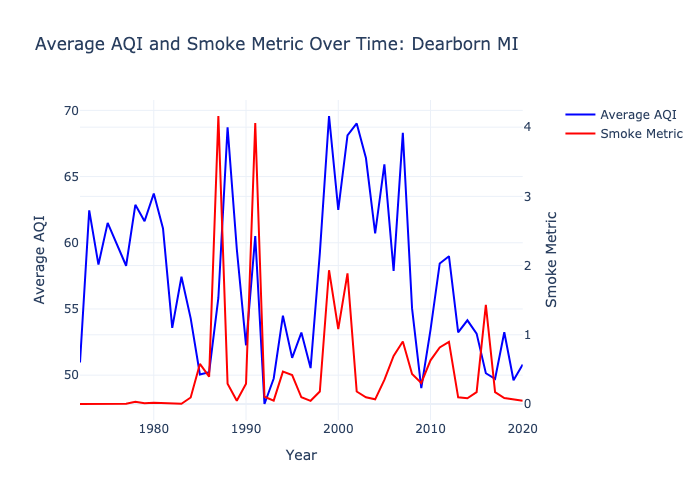

In [17]:
# Create subplots with secondary y-axis enabled
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Add traces
fig.add_trace(
    go.Scatter(x=dearborn_mi_aqi_df_yearly ['Year'], y=dearborn_mi_aqi_df_yearly ['Average_AQI'], name="Average AQI", line=dict(color="blue")),
    secondary_y=False, 
)
fig.add_trace(
    go.Scatter(x=dearborn_mi_aqi_df_yearly ['Year'], y=dearborn_mi_aqi_df_yearly ['SmokeMetric'], name="Smoke Metric", line=dict(color="red")),
    secondary_y=True,  
)
# Update layout for dual y-axis titles
fig.update_layout(
    title_text="Average AQI and Smoke Metric Over Time: Dearborn MI",
    xaxis_title="Year",
    yaxis_title="Average AQI",
    yaxis2_title="Smoke Metric",
    template='plotly_white'
)
# Show the figure
fig.write_image("./imgs/aqi_smoke_metric_line_plot.png")
img = Image.open("./imgs/aqi_smoke_metric_line_plot.png")
display(img)

#### Comparing AQI and Smoke Metric

From this plot we can clearly see that:
 1. The smoke metric and AQI actually follow similar trends
 2. The smoke metric is very low before 1984. 

 This is likely a result of poor data collection before 1984. To that end, we should compare the correlation when filtering these years out, and keeping them in. I choose to use the spearman correlation, since it's clear the magnitude of change isn't the same over time. Therefore, the relationship is likely non-parametric, and requires a rank based approach.

In [18]:
result = spearmanr(dearborn_mi_aqi_df_yearly['Average_AQI'], dearborn_mi_aqi_df_yearly['SmokeMetric'])
print(f"""Prior to removing the years before 1984, we see the correlation between AQI and Smoke Metric is 
fairly low at R = {round(result.statistic, 3)}. This result is also not very statistically significant at p = {round(result.pvalue, 3)}""")

Prior to removing the years before 1984, we see the correlation between AQI and Smoke Metric is 
fairly low at R = 0.063. This result is also not very statistically significant at p = 0.671


In [19]:
filtered_correlation_df = dearborn_mi_aqi_df_yearly[dearborn_mi_aqi_df_yearly['Year'] >= 1984]
refined_result = spearmanr(filtered_correlation_df['Average_AQI'], filtered_correlation_df['SmokeMetric'])
print(f"""After removing the years before 1984, we see the correlation between AQI and Smoke Metric is 
appreciable at R = {round(refined_result.statistic, 3)}. This result is also statistically significant at p = {round(refined_result.pvalue, 3)}""")

After removing the years before 1984, we see the correlation between AQI and Smoke Metric is 
appreciable at R = 0.354. This result is also statistically significant at p = 0.031


Hence, I conclude that in the years for which we likely have good data collection (1984 and onwards), the smoke metric decently approximates the change in AQI over time.

#### Forecasting Smoke Metrics 2025-2050
##### In Collaboration with Alex Netzley and Jake Flynn

I chose to use an ExponentialSmoothing time series model from the Holt-Winters method for Time Series Forecasting. In order to use this method, we have to set the index to be the year, and specify the frequency. Use of this method, including some sample code, can be attributed to collaboration with Jake Flynn and Alex Netzley. 

In [20]:
fire_df_650mi_ts = fire_df_650mi.copy()
fire_df_650mi_ts["Year"] = pd.to_datetime(fire_df_650mi_ts["Year"], format='%Y')
fire_df_650mi_ts = fire_df_650mi_ts.set_index("Year")
fire_df_650mi_ts = fire_df_650mi_ts.asfreq("YS-JAN")

Next we fit the model. We note above regular peaks and valleys in the trend for smoke metric. Therefore, we can assume there is some seasonality. Peaks are often spaced 3-4 years apart. It is likely we have none before 1985 before of poor data collection. Therefore we take the 60 year time period and divide by 3 years, resulting in about 20 seasonal periods in the data.

In [21]:
#fit exponential smoothing model
ts_model = ExponentialSmoothing(
    fire_df_650mi_ts,
    trend="add",
    seasonal="add",
    seasonal_periods = 20,
).fit()
#get forecast per year
forecast_per_year = ts_model.forecast(steps = 31)

Next, we manually calculate the confidence intervals.

In [22]:
residuals = ts_model.resid
sigma = np.std(residuals) 
# Calculate the confidence intervals
alpha = 0.05 
z_score = 1.96 
# Calculate the lower and upper bounds of the confidence intervals
lower_bounds = forecast_per_year - z_score * sigma
upper_bounds = forecast_per_year + z_score * sigma

Next, we do some data manipulation to create the forecast dataframe.

In [23]:
forecast_df = pd.DataFrame({"SmokeMetric" : list(forecast_per_year),
                            "Year" : pd.DataFrame(forecast_per_year).index,
                            "LowerCI" : list(lower_bounds),
                            "UpperCI" : list(upper_bounds)})
#Extract year
forecast_df.Year = forecast_df.Year.dt.year
#Shrink CI floor to 0, which is the lowest possible value
forecast_df.loc[forecast_df['LowerCI'] < 0, 'LowerCI'] = 0

We add the datapoint from 2021 to the original, non-predicted dataframe to make the lines on the graph connect.

In [24]:
#add a row
fire_df_650mi = pd.concat([fire_df_650mi, 
                           pd.DataFrame({"Year" : [2021],
                                         "SmokeMetric" : forecast_df[forecast_df["Year"] == 2021]["SmokeMetric"]})])

Finally, we visualize the entire time series, including the pre-computed values and the predictions.

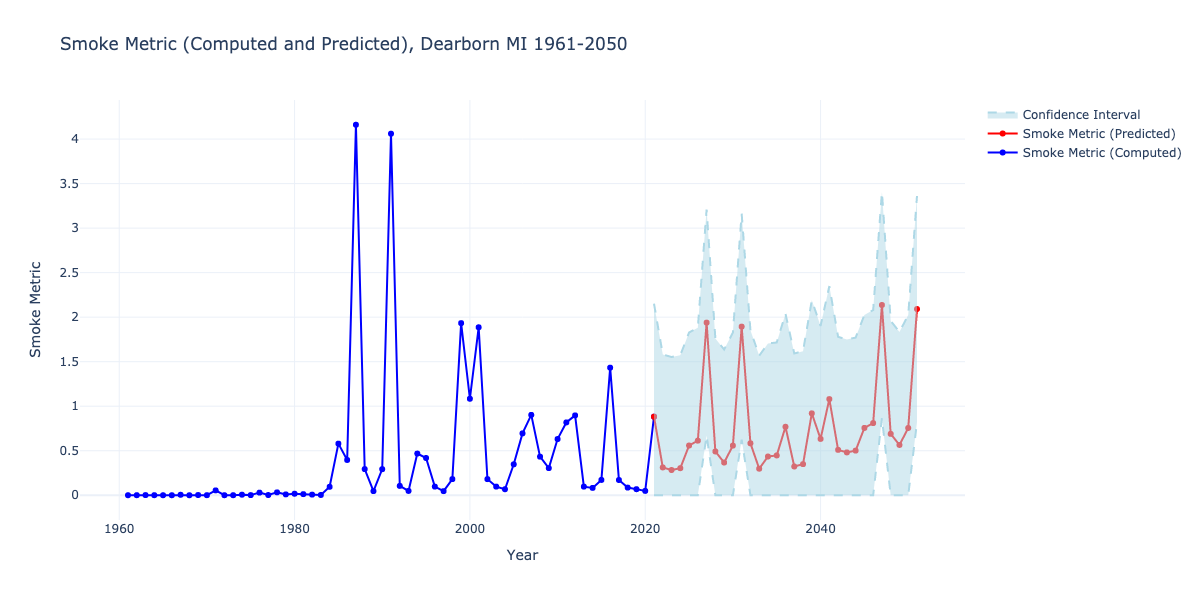

In [25]:
# Create the figure
fig = go.Figure()

# Add the SmokeMetric as a line plot
fig.add_trace(go.Scatter(
    x=fire_df_650mi["Year"],
    y=fire_df_650mi['SmokeMetric'],
    mode='lines+markers',
    name='Smoke Metric (Computed)',
    line=dict(color='blue')
))

#predicted smoke metric
fig.add_trace(go.Scatter(
    x=forecast_df["Year"],
    y=forecast_df['SmokeMetric'],
    mode='lines+markers',
    name='Smoke Metric (Predicted)',
    line=dict(color='red')
))
#Lower CI
fig.add_trace(go.Scatter(
    x=forecast_df['Year'],
    y=forecast_df['LowerCI'],
    mode='lines',
    name='Confidence Interval',
    line=dict(color='lightblue', dash='dash'),
    fill=None,
    showlegend = False
))
#Upper CI
fig.add_trace(go.Scatter(
    x=forecast_df['Year'],
    y=forecast_df['UpperCI'],
    mode='lines',
    name='Confidence Interval',  # Same label for the upper bound
    line=dict(color='lightblue', dash='dash'),
    fill='tonexty',  # Fill the area between the lines
    fillcolor='rgba(173, 216, 230, 0.5)'  # Light blue fill
))

# Update layout
fig.update_layout(
    title='Smoke Metric (Computed and Predicted), Dearborn MI 1961-2050',
    xaxis_title='Year',
    yaxis_title='Smoke Metric',
    template='plotly_white',
    width = 1200,
    height = 600
)

# Show the plot
fig.write_image("./imgs/smoke_metric_line_plot_forecast.png")
img = Image.open("./imgs/smoke_metric_line_plot_forecast.png")
display(img)